# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [ ]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
project_folder='Project_data'

In [ ]:
## Func to visualise accuracy and loss
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

### Sample Cropping

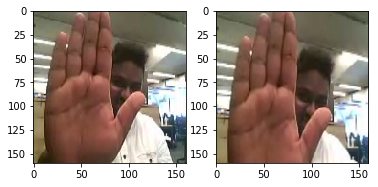

In [ ]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

In [ ]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error:
ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


### Few Experiments to analyse how training time and validation accuracy is affected by batch size, no. of images in sequence and image resolution:

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - 138s 6s/step - loss: 1.4474 - categorical_accuracy: 0.4750 - val_loss: 2.6125 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_2020-06-2715_15_18.409820/model-00001-1.45806-0.46757-2.61252-0.34000.h5
Epoch 2/3
23/23 [==============================] - 47s 2s/step - loss: 1.0812 - categorical_accuracy: 0.5662 - val_loss: 2.9923 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2020-06-2715_15_18.409820/model-00002-1.05233-0.58824-2.99227-0.26000.h5
Epoch 3/3
23/23 [==============================] - 48s 2s/step - loss: 0.9188 - categorical_accuracy: 0.6356 - val_loss: 1.8100 - val_categorical_accuracy: 0.3500

Epoch 00003: saving model to model_init_2020-06-2715_15_18.409820/model-00003-0.94861-0.62142-1.80997-0.35000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - 165s 7s/step - loss: 1.7659 - categorical_accuracy: 0.3304 - val_loss: 1.6853 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-06-2812_00_16.470973/model-00001-1.77010-0.33032-1.68532-0.44000.h5
Epoch 2/2
23/23 [==============================] - 73s 3s/step - loss: 1.2013 - categorical_accuracy: 0.5003 - val_loss: 1.4236 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2020-06-2812_00_16.470973/model-00002-1.20377-0.50679-1.42364-0.46000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 91s 8s/step - loss: 1.6657 - categorical_accuracy: 0.3633 - val_loss: 2.1297 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_2020-06-2812_05_37.998548/model-00001-1.75681-0.33937-2.12974-0.34000.h5
Epoch 2/2
12/12 [==============================] - 73s 6s/step - loss: 1.2018 - categorical_accuracy: 0.5045 - val_loss: 1.7285 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2020-06-2812_05_37.998548/model-00002-1.24325-0.49170-1.72854-0.40000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 98s 2s/step - loss: 1.5858 - categorical_accuracy: 0.4371 - val_loss: 3.1527 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2020-06-2812_11_16.794376/model-00001-1.59271-0.43891-3.15269-0.29000.h5
Epoch 2/2
45/45 [==============================] - 86s 2s/step - loss: 1.1250 - categorical_accuracy: 0.5482 - val_loss: 1.5918 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-06-2812_11_16.794376/model-00002-1.10777-0.55204-1.59179-0.52000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 54s 1s/step - loss: 1.6066 - categorical_accuracy: 0.3822 - val_loss: 1.2204 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2020-06-2812_15_13.651467/model-00001-1.61387-0.38311-1.22039-0.54000.h5
Epoch 2/2
45/45 [==============================] - 45s 994ms/step - loss: 1.1504 - categorical_accuracy: 0.5601 - val_loss: 0.8743 - val_categorical_accuracy: 0.7000

Epoch 00002: saving model to model_init_2020-06-2812_15_13.651467/model-00002-1.13907-0.56410-0.87425-0.70000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - 52s 774ms/step - loss: 1.6370 - categorical_accuracy: 0.3677 - val_loss: 1.1881 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-06-2812_17_55.629634/model-00001-1.64344-0.36802-1.18813-0.53000.h5
Epoch 2/2
67/67 [==============================] - 45s 676ms/step - loss: 1.2558 - categorical_accuracy: 0.4841 - val_loss: 1.0299 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2020-06-2812_17_55.629634/model-00002-1.24523-0.48567-1.02990-0.56000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - 58s 3s/step - loss: 1.5889 - categorical_accuracy: 0.4071 - val_loss: 1.5133 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-06-2812_20_19.220909/model-00001-1.59762-0.40121-1.51328-0.36000.h5
Epoch 2/2
17/17 [==============================] - 42s 2s/step - loss: 0.9548 - categorical_accuracy: 0.6363 - val_loss: 1.0003 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2020-06-2812_20_19.220909/model-00002-0.94619-0.63801-1.00031-0.54000.h5


### Few Observations made:
1. Image resolution and number of frames in sequence have more impact on training time than batch_size. 
2. Though Higher resolution is giving better validation accuracy. So we need to keep a balance. 

So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints .

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

## Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 10, 80, 80, 32)    128       
__________

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 129s 8s/step - loss: 1.4444 - categorical_accuracy: 0.4718 - val_loss: 1.9930 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-06-2715_21_50.523285/model-00001-1.44071-0.47059-1.99304-0.46000.h5
Epoch 2/15
17/17 [==============================] - 56s 3s/step - loss: 0.9412 - categorical_accuracy: 0.6207 - val_loss: 1.7345 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to model_init_2020-06-2715_21_50.523285/model-00002-0.94524-0.61991-1.73450-0.48000.h5
Epoch 3/15
17/17 [==============================] - 59s 3s/step - loss: 0.7714 - categorical_accuracy: 0.7095 - val_loss: 1.2080 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2020-06-2715_21_50.523285/model-00003-0.76902-0.71192-1.20799-0.58000.h5
Epoch 4/15
17/17 [==============================] - 59s 3s/step - loss: 0.5329 - categorical_accuracy: 0.8043 - val_loss: 0.8828 - val_categori

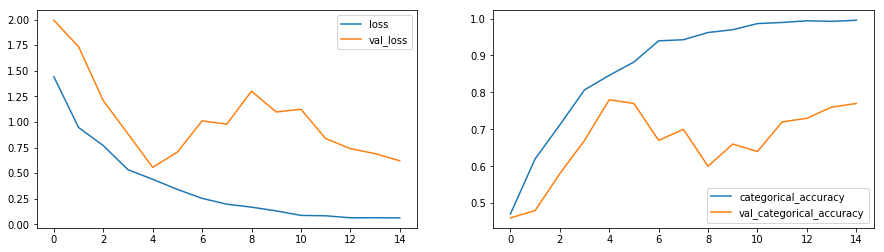

In [ ]:
plot(history_model1)

#### We can clearly figure out that the model is overfitting. Next, we do data augmentation.

## Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [ ]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_14 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 10, 80, 80, 32)    128       
__________

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 142s 4s/step - loss: 1.9806 - categorical_accuracy: 0.3653 - val_loss: 2.8184 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-06-2715_39_43.961799/model-00001-1.97892-0.36199-2.81840-0.36000.h5
Epoch 2/25
34/34 [==============================] - 129s 4s/step - loss: 1.4401 - categorical_accuracy: 0.4761 - val_loss: 12.3271 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2020-06-2715_39_43.961799/model-00002-1.43754-0.47964-12.32710-0.23000.h5
Epoch 3/25
34/34 [==============================] - 133s 4s/step - loss: 1.2108 - categorical_accuracy: 0.5699 - val_loss: 1.6587 - val_categorical_accuracy: 0.6800

Epoch 00003: saving model to model_init_2020-06-2715_39_43.961799/model-00003-1.21467-0.57164-1.65867-0.68000.h5
Epoch 4/25
34/34 [==============================] - 134s 4s/step - loss: 1.0450 - categorical_accuracy: 0.6266 - val_loss: 1.5991 - val_cat

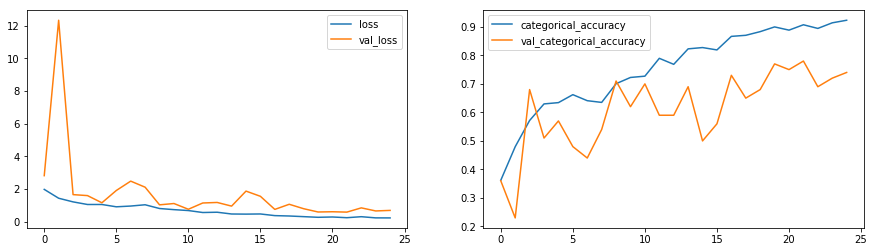

In [ ]:
plot(history_model2)

#### This model is overfitting less as compared to base model.


## Model 3 - Reduce filter size to (2,2,2) and image res to 120 x 120

In [ ]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_29 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_30 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 8, 60, 60, 32)     128       
__________

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 96s 4s/step - loss: 2.2882 - categorical_accuracy: 0.2831 - val_loss: 1.1193 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2020-06-2812_40_06.481149/model-00001-2.24414-0.29412-1.11933-0.52000.h5
Epoch 2/30
23/23 [==============================] - 81s 4s/step - loss: 1.5374 - categorical_accuracy: 0.4623 - val_loss: 1.0049 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model_init_2020-06-2812_40_06.481149/model-00002-1.55886-0.46078-1.00488-0.59000.h5
Epoch 3/30
23/23 [==============================] - 89s 4s/step - loss: 1.4428 - categorical_accuracy: 0.5010 - val_loss: 0.9963 - val_categorical_accuracy: 0.6200

Epoch 00003: saving model to model_init_2020-06-2812_40_06.481149/model-00003-1.40303-0.50754-0.99631-0.62000.h5
Epoch 4/30
23/23 [==============================] - 90s 4s/step - loss: 1.1727 - categorical_accuracy: 0.5793 - val_loss: 1.0295 - val_categoric

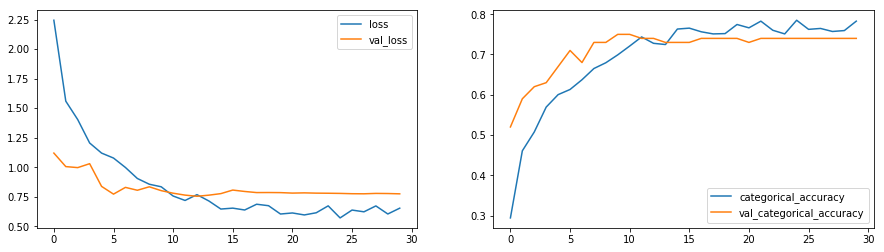

In [ ]:
plot(history_model3)

#### This model has approximately half the parameters w.r.t Model 2 with similar accuracy !

## Model 4 - Adding more layers

In [ ]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_34 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [ ]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 118s 3s/step - loss: 2.0308 - categorical_accuracy: 0.3532 - val_loss: 10.7200 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2020-06-2813_39_32.593448/model-00001-2.04162-0.34540-10.72004-0.22000.h5
Epoch 2/30
34/34 [==============================] - 95s 3s/step - loss: 1.5959 - categorical_accuracy: 0.4551 - val_loss: 2.1218 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2020-06-2813_39_32.593448/model-00002-1.57888-0.45400-2.12181-0.40000.h5
Epoch 3/30
34/34 [==============================] - 95s 3s/step - loss: 1.4718 - categorical_accuracy: 0.4606 - val_loss: 1.3633 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-06-2813_39_32.593448/model-00003-1.49616-0.45551-1.36328-0.50000.h5
Epoch 4/30
34/34 [==============================] - 95s 3s/step - loss: 1.2982 - categorical_accuracy: 0.5401 - val_loss: 0.9409 - val_catego

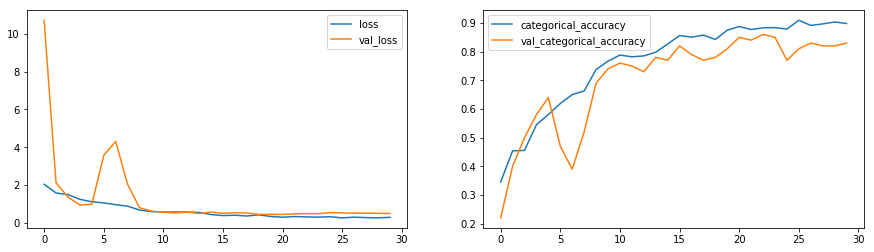

In [ ]:
plot(history_model4)

#### Adding layers has definitely helped with the accuracy and the model doesnot overfit !

## Model 5- Adding dropout at convolution layers

In [ ]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_41 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_42 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [ ]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - 112s 3s/step - loss: 1.7480 - categorical_accuracy: 0.3745 - val_loss: 4.0288 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2020-06-2814_41_15.297103/model-00001-1.74572-0.37557-4.02876-0.29000.h5
Epoch 2/22
34/34 [==============================] - 95s 3s/step - loss: 1.2601 - categorical_accuracy: 0.5007 - val_loss: 3.3391 - val_categorical_accuracy: 0.3500

Epoch 00002: saving model to model_init_2020-06-2814_41_15.297103/model-00002-1.25313-0.50905-3.33914-0.35000.h5
Epoch 3/22
34/34 [==============================] - 96s 3s/step - loss: 1.0674 - categorical_accuracy: 0.5993 - val_loss: 2.1348 - val_categorical_accuracy: 0.4000

Epoch 00003: saving model to model_init_2020-06-2814_41_15.297103/model-00003-1.04487-0.60181-2.13479-0.40000.h5
Epoch 4/22
34/34 [==============================] - 100s 3s/step - loss: 0.9633 - categorical_accuracy: 0.6218 - val_loss: 5.6821 - val_categor

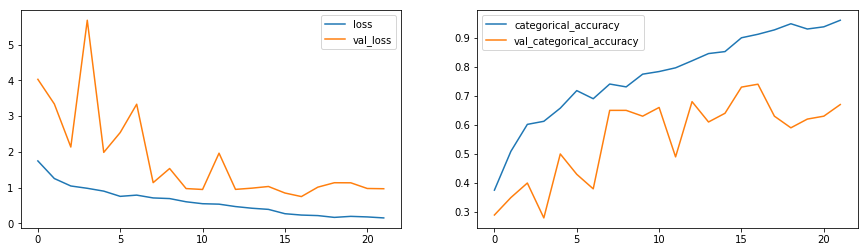

In [ ]:
plot(history_model5)

#### Adding dropouts at convulational layers has reduced validation accuracy a lot ! 

## Model 6- Reducing Parameters

In [ ]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=120,image_width=120)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=64,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_18 (Activation)   (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 60, 60, 16)     64        
__________

In [ ]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 94s 3s/step - loss: 2.1263 - categorical_accuracy: 0.2535 - val_loss: 1.5741 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to model_init_2020-06-2716_41_21.344018/model-00001-2.12539-0.25566-1.57407-0.38000.h5
Epoch 2/30
34/34 [==============================] - 85s 2s/step - loss: 1.5689 - categorical_accuracy: 0.3878 - val_loss: 1.4148 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2020-06-2716_41_21.344018/model-00002-1.56198-0.38914-1.41477-0.44000.h5
Epoch 3/30
34/34 [==============================] - 88s 3s/step - loss: 1.3997 - categorical_accuracy: 0.4577 - val_loss: 1.2775 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2020-06-2716_41_21.344018/model-00003-1.39152-0.46078-1.27751-0.49000.h5
Epoch 4/30
34/34 [==============================] - 88s 3s/step - loss: 1.2504 - categorical_accuracy: 0.5081 - val_loss: 1.3182 - val_categorica

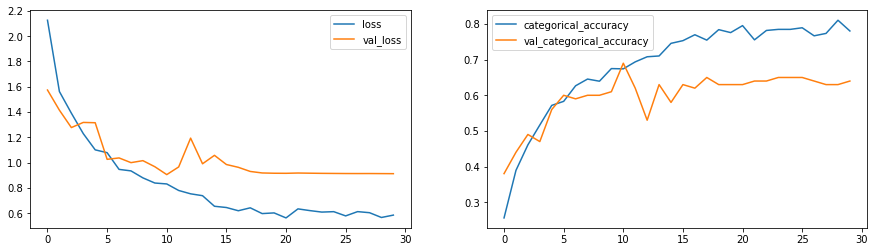

In [ ]:
plot(history_model6)

## More Augmentation 

In [ ]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [ ]:
class ModelConv3D7(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=160,image_width=160)
conv_3d7.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d7_model=conv_3d7.define_model(dense_neurons=256,dropout=0.5)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_22 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 10, 80, 80, 32)    128       
__________

In [ ]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - 145s 4s/step - loss: 2.0800 - categorical_accuracy: 0.3274 - val_loss: 1.1205 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-06-2717_41_53.476232/model-00001-2.07325-0.32730-1.12048-0.58000.h5
Epoch 2/30
34/34 [==============================] - 133s 4s/step - loss: 1.4878 - categorical_accuracy: 0.4768 - val_loss: 0.9696 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-06-2717_41_53.476232/model-00002-1.50687-0.47210-0.96965-0.60000.h5
Epoch 3/30
34/34 [==============================] - 136s 4s/step - loss: 1.3156 - categorical_accuracy: 0.5390 - val_loss: 1.0747 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-06-2717_41_53.476232/model-00003-1.31123-0.53997-1.07475-0.61000.h5
Epoch 4/30
34/34 [==============================] - 137s 4s/step - loss: 1.1564 - categorical_accuracy: 0.6038 - val_loss: 1.1395 - val_categ

34/34 [==============================] - 135s 4s/step - loss: 0.3663 - categorical_accuracy: 0.8709 - val_loss: 0.7187 - val_categorical_accuracy: 0.7600

Epoch 00030: saving model to model_init_2020-06-2717_41_53.476232/model-00030-0.37136-0.87179-0.71867-0.76000.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.


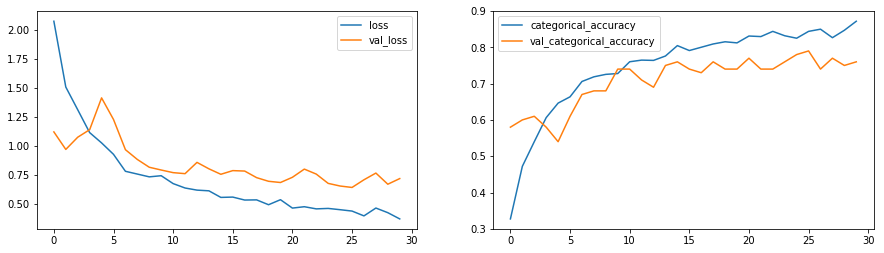

In [ ]:
plot(history_model7)